<a href="https://colab.research.google.com/github/mcnica89/DATA6100_F23/blob/main/Shrinkage_Methods/lab_06_6_ridge_and_lasso_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Based on the statlearning lab and also from http://www.science.smith.edu/~jcrouser/SDS293/labs/

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Load the dataset

In [2]:
# imports and setup
%matplotlib inline

from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

#pd.set_option('precision', 4) # number precision for pandas
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 12)
pd.set_option('display.float_format', '{:20,.5f}'.format) # get rid of scientific notation

plt.style.use('seaborn') # pretty matplotlib plots

In [3]:
hitters = pd.read_csv('https://raw.githubusercontent.com/mcnica89/ISL-python/master/datasets/Hitters.csv', index_col=0).dropna()
hitters.index.name = 'Player'

hitters = hitters.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,18]] # push salary at the end

hitters['League'] = pd.get_dummies(hitters['League']).iloc[:, 1]
hitters['Division'] = pd.get_dummies(hitters['Division']).iloc[:, 1]
hitters['NewLeague'] = pd.get_dummies(hitters['NewLeague']).iloc[:, 1]

X = hitters.iloc[:, 0:19]
y = hitters.iloc[:, 19]

In [4]:
hitters.head

<bound method NDFrame.head of                    AtBat  Hits  HmRun  Runs  RBI  Walks  ...  Division  \
Player                                                   ...             
-Alan Ashby          315    81      7    24   38     39  ...         1   
-Alvin Davis         479   130     18    66   72     76  ...         1   
-Andre Dawson        496   141     20    65   78     37  ...         0   
-Andres Galarraga    321    87     10    39   42     30  ...         0   
-Alfredo Griffin     594   169      4    74   51     35  ...         1   
...                  ...   ...    ...   ...  ...    ...  ...       ...   
-Willie McGee        497   127      7    65   48     37  ...         0   
-Willie Randolph     492   136      5    76   50     94  ...         0   
-Wayne Tolleson      475   126      3    61   43     52  ...         1   
-Willie Upshaw       573   144      9    85   60     78  ...         0   
-Willie Wilson       631   170      9    77   44     31  ...         1   

       

# Normalize the Data before running any Lp regularization!

In [5]:
def my_normalize_func(df):
  #returns the standardized version of a dataframe, as well as the list of means and stds (in case you need to un-normalize)
  means_series = df.mean()
  std_devs_series = df.std()
  normalized_df = (df-df.mean())/df.std()
  return normalized_df,means_series,std_devs_series

#Uncomment to run this!
X_normalized,X_raw_means,X_raw_std_devs = my_normalize_func(X)
print("X is now normalized!")
print("-----Means----\n",X_raw_means)
print("-----Std Devs----\n ",X_raw_std_devs)

X = X_normalized
X.head

X is now normalized!
-----Means----
 AtBat                  403.64259
Hits                   107.82890
HmRun                   11.61977
Runs                    54.74525
RBI                     51.48669
Walks                   41.11407
Years                    7.31179
CAtBat               2,657.54373
CHits                  722.18631
CHmRun                  69.23954
CRuns                  361.22053
CRBI                   330.41825
CWalks                 260.26616
League                   0.47148
Division                 0.50951
PutOuts                290.71103
Assists                118.76046
Errors                   8.59316
NewLeague                0.46388
dtype: float64
-----Std Devs----
  AtBat                  147.30721
Hits                    45.12533
HmRun                    8.75711
Runs                    25.53982
RBI                     25.88271
Walks                   21.71806
Years                    4.79362
CAtBat               2,286.58293
CHits                  648.19964
CHmR

<bound method NDFrame.head of                                  AtBat                 Hits  \
Player                                                        
-Alan Ashby                   -0.60175             -0.59454   
-Alvin Davis                   0.51157              0.49132   
-Andre Dawson                  0.62697              0.73509   
-Andres Galarraga             -0.56102             -0.46158   
-Alfredo Griffin               1.29225              1.35558   
...                                ...                  ...   
-Willie McGee                  0.63376              0.42484   
-Willie Randolph               0.59982              0.62429   
-Wayne Tolleson                0.48441              0.40268   
-Willie Upshaw                 1.14969              0.80157   
-Willie Wilson                 1.54342              1.37774   

                                 HmRun                 Runs  \
Player                                                        
-Alan Ashby             

# Ordinary Least Squares

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
#simple linear regressions
ols_model = LinearRegression()
ols_fit = ols_model.fit(X_train, y_train)
y_pred = ols_model.predict(X_test)

print(pd.Series(ols_fit.coef_, index=X.columns))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

AtBat                 -217.80907
Hits                   334.93126
HmRun                   41.91391
Runs                   -72.89873
RBI                    -37.34561
Walks                  120.60898
Years                   38.62371
CAtBat                -526.69103
CHits                   70.70018
CHmRun                 -38.62878
CRuns                  558.82023
CRBI                   304.48091
CWalks                -216.67987
League                  53.99540
Division               -57.02015
PutOuts                 69.40346
Assists                 32.77630
Errors                  -4.30004
NewLeague              -31.85278
dtype: float64
RMSE: 358.168040864513


# 6.6.1 Ridge Regression

## How do the coeffiencts change as a function of the regularization param?

In [8]:
grid = 10 ** np.linspace(3,-2,100)

ridge_model = Ridge()
coefs = []

for a in grid:
    ridge_model.set_params(alpha=a)
    ridge_model.fit(X, y)
    coefs.append(ridge_model.coef_)

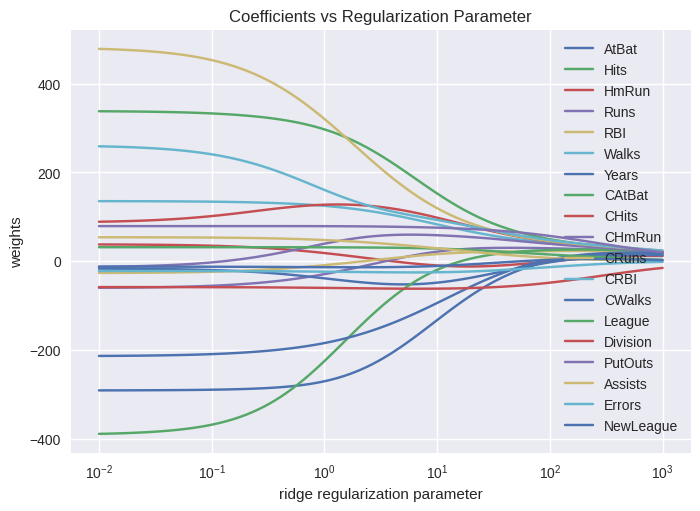

In [9]:
ax = plt.gca()
ax.plot(grid, coefs)
ax.set_xscale('log')
ax.legend(X.columns)

plt.title("Coefficients vs Regularization Parameter")
plt.axis('tight')
plt.xlabel('ridge regularization parameter')
plt.ylabel('weights');

# Using Validation to find the "best" regularization parameter

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

grid = 10 ** np.linspace(3,-2,100)

ridge_model = Ridge()
coefs = []
test_RMSE = []


for a in grid:
    ridge_model.set_params(alpha=a)
    ridge_model.fit(X_train, y_train)
    coefs.append(ridge_model.coef_)

    preds = ridge_model.predict(X_test)

    test_RMSE.append( np.sqrt(np.mean( (preds - y_test)**2 ) ))

Best regularization value found:  123.28467394420659


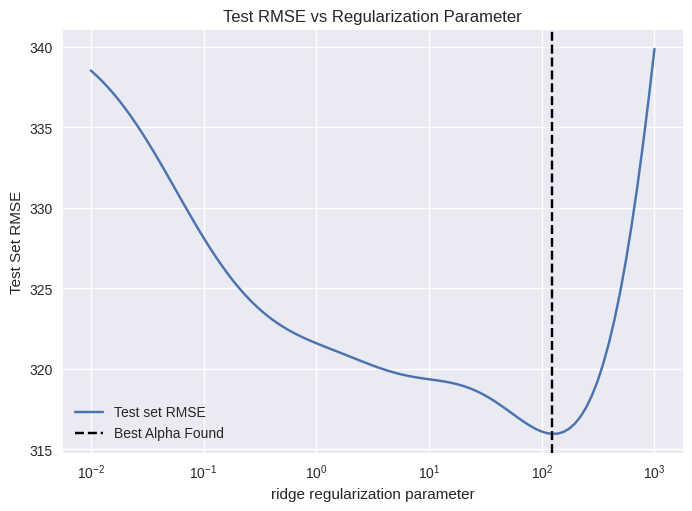

In [12]:
ax = plt.gca()
ax.plot(grid, test_RMSE,label="Test set RMSE")
best_alpha = grid[np.argmin(test_RMSE)]
ax.axvline(best_alpha,color='k',linestyle='--',label='Best Alpha Found')
ax.legend()
ax.set_xscale('log')
plt.title("Test RMSE vs Regularization Parameter")
plt.axis('tight')
plt.xlabel('ridge regularization parameter')
plt.ylabel('Test Set RMSE');

print("Best regularization value found: ", grid[np.argmin(test_RMSE)]  )

# How to trying different ridge params

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [14]:
# "good" ridge model
ridge2 = Ridge(alpha=1.0)
ridge2_fit = ridge2.fit(X_train, y_train)
y_pred2 = ridge2.predict(X_test)

print(pd.Series(ridge2_fit.coef_, index=X.columns))
print('MSE:', mean_squared_error(y_test, y_pred2))

AtBat                 -327.32461
Hits                   291.22433
HmRun                  -48.09073
Runs                   -23.09185
RBI                     85.07917
Walks                  103.54968
Years                  -15.67170
CAtBat                -334.06800
CHits                  179.68742
CHmRun                  77.39465
CRuns                  218.63582
CRBI                   145.38696
CWalks                 -71.83655
League                  48.66747
Division               -58.55295
PutOuts                119.81668
Assists                 45.26021
Errors                 -23.46385
NewLeague              -30.01265
dtype: float64
MSE: 103419.77016744926


In [15]:
# very high lambda
ridge3 = Ridge(alpha=1e10)
ridge3_fit = ridge3.fit(X_train, y_train)
y_pred3 = ridge3.predict(X_test)

print(pd.Series(ridge3_fit.coef_, index=X.columns))
print('MSE:', mean_squared_error(y_test, y_pred3))

AtBat                    0.00000
Hits                     0.00000
HmRun                    0.00000
Runs                     0.00000
RBI                      0.00000
Walks                    0.00000
Years                    0.00000
CAtBat                   0.00000
CHits                    0.00000
CHmRun                   0.00000
CRuns                    0.00000
CRBI                     0.00000
CWalks                   0.00000
League                  -0.00000
Division                -0.00000
PutOuts                  0.00000
Assists                 -0.00000
Errors                   0.00000
NewLeague               -0.00000
dtype: float64
MSE: 172862.22020055173


In [16]:
# lambda=0 -> OLS
ridge4 = Ridge(alpha=0)
ridge4_fit = ridge4.fit(X_train, y_train)
y_pred4 = ridge4.predict(X_test)

print(pd.Series(ridge4_fit.coef_, index=X.columns))
print('MSE:', mean_squared_error(y_test, y_pred4))

AtBat                 -268.26336
Hits                   192.19581
HmRun                  -41.80119
Runs                    -0.98993
RBI                    103.13169
Walks                   75.36438
Years                   45.53090
CAtBat              -1,383.67711
CHits                1,409.82084
CHmRun                 244.89172
CRuns                   88.21675
CRBI                  -193.52127
CWalks                  45.25458
League                  66.89002
Division               -56.97007
PutOuts                117.87015
Assists                 67.37244
Errors                 -39.80181
NewLeague              -40.93474
dtype: float64
MSE: 116690.46856661266


# Automatically choosing the best parameter with RidgeCV

In [17]:
# cross validated ridge (10-fold)
# Automatically do 10 fold cross validation to choose the best ridge parameter
ridge_cv = RidgeCV(alphas=grid, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)
print("Best regularization param value found: ", ridge_cv.alpha_)

Best regularization param value found:  77.4263682681127


In [18]:
# cv_lambda
ridge5 = Ridge(alpha=ridge_cv.alpha_)
ridge5_fit = ridge5.fit(X_train, y_train)
y_pred5 = ridge5.predict(X_test)

print(pd.Series(ridge5_fit.coef_, index=X.columns))
print('Best Ridge Value: ',ridge_cv.alpha_)
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred5)))

AtBat                   -2.90895
Hits                    39.26869
HmRun                   -2.83183
Runs                    17.94075
RBI                     32.16549
Walks                   47.50329
Years                    5.52613
CAtBat                  14.59555
CHits                   32.87150
CHmRun                  45.40197
CRuns                   32.60768
CRBI                    46.37891
CWalks                  22.04670
League                   9.45560
Division               -45.45713
PutOuts                 81.70288
Assists                 -1.81287
Errors                  -2.30093
NewLeague                4.73170
dtype: float64
Best Ridge Value:  77.4263682681127
RMSE: 316.4954302841295


# The Lasso

In [19]:
def plot_lasso_regression(X_train,y_train,X_test,y_test,grid = None):
  if grid is None:
    grid = 10 ** np.linspace(3,-2,100)

  lasso_model = Lasso(max_iter=10000) # max_iter=10000 for removing ConvergenceWarning
  coefs = []
  test_RMSE = []

  for a in grid:
      lasso_model.set_params(alpha=a)
      lasso_model.fit(X_train, y_train)
      coefs.append(lasso_model.coef_)

      preds = lasso_model.predict(X_test)

      test_RMSE.append( np.sqrt(np.mean( (preds - y_test)**2 ) ))

  ax = plt.gca()
  ax.plot(grid, coefs)
  ax.set_xscale('log')
  ax.legend(X.columns)

  plt.axis('tight')
  plt.xlabel('alpha')
  plt.title("Coeff Values vs Lasso Parameter")
  plt.ylabel('weights')
  plt.figure()

  ax = plt.gca()
  ax.plot(grid, test_RMSE,label="Test set RMSE")
  best_alpha = grid[np.argmin(test_RMSE)]
  ax.axvline(best_alpha,color='k',linestyle='--',label='Best Alpha Found')
  ax.legend()
  ax.set_xscale('log')
  plt.title("Test RMSE vs Regularization Parameter")
  plt.axis('tight')
  plt.xlabel('Lasso regularization parameter')
  plt.ylabel('Test Set RMSE');


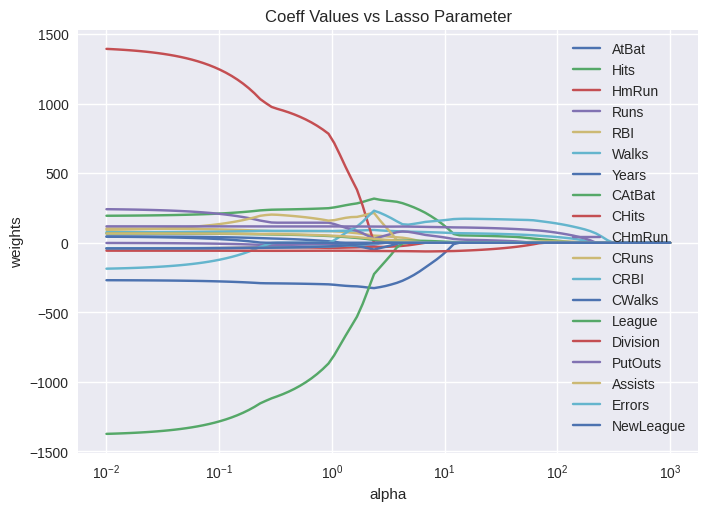

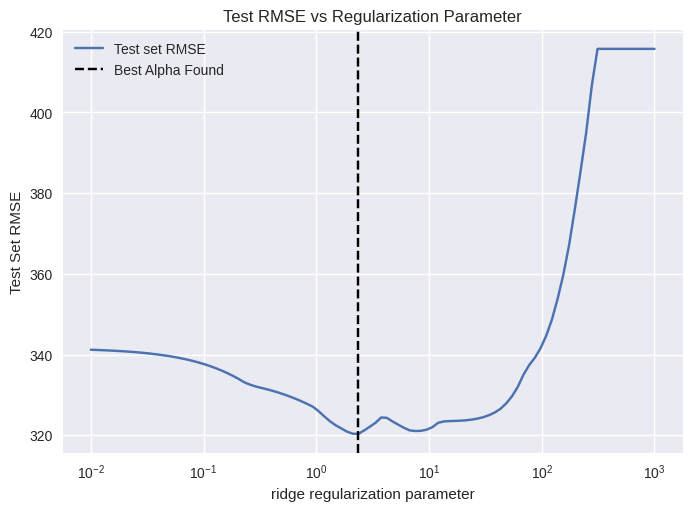

In [20]:
plot_lasso_regression(X_train,y_train,X_test,y_test)

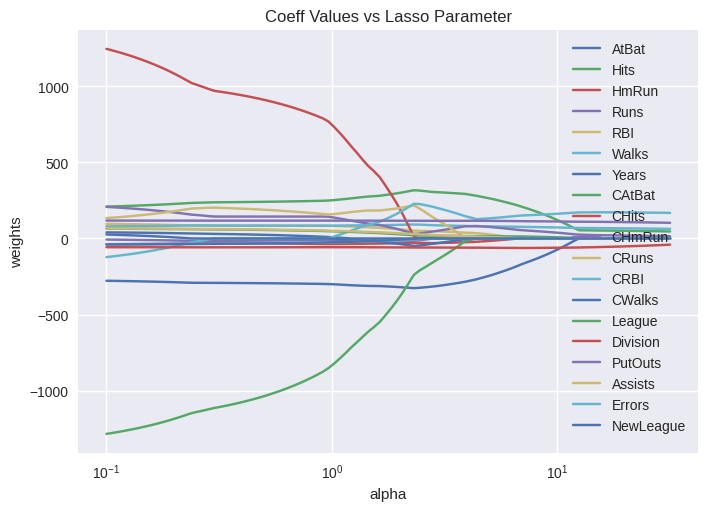

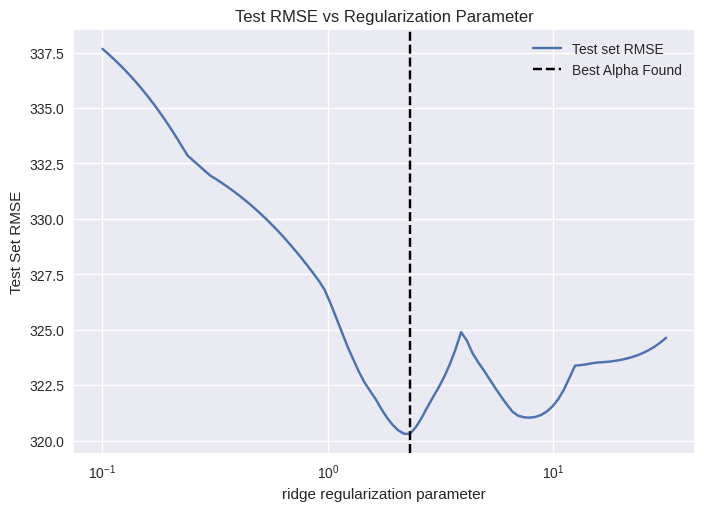

In [21]:
plot_lasso_regression(X_train,y_train,X_test,y_test,  grid = 10 ** np.linspace(-1,1.5,100))

In [22]:
lasso_cv = LassoCV(alphas=grid, max_iter=100000, cv=10)
lasso_cv.fit(X_train, y_train)
lasso_cv.alpha_

27.185882427329414

In [23]:
lasso2 = Lasso(alpha=lasso_cv.alpha_, max_iter=10000)
lasso2_fit = lasso2.fit(X_train, y_train)
y_pred2 = lasso2_fit.predict(X_test)

print(pd.Series(lasso2_fit.coef_, index=X.columns))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred2)))

AtBat                    0.00000
Hits                    47.82183
HmRun                    0.00000
Runs                     0.00000
RBI                      0.00000
Walks                   64.38384
Years                    0.00000
CAtBat                   0.00000
CHits                    0.00000
CHmRun                  16.61545
CRuns                    0.00000
CRBI                   169.49929
CWalks                   0.00000
League                   0.00000
Division               -44.82426
PutOuts                104.71734
Assists                 -0.00000
Errors                  -0.00000
NewLeague                0.00000
dtype: float64
RMSE: 324.14555093161164
